In [1]:
# Credit to CrunchBase, for their noble Open Data Map initiative!
# read more about it here:
# https://data.crunchbase.com/page/crunchbase-open-data-map-odm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
fpath = r'data/odm/organizations.csv'

In [4]:
df = pd.read_csv(fpath)

In [5]:
df.head()

,crunchbase_uuid,type,primary_role,name,crunchbase_url,homepage_domain,homepage_url,profile_image_url,facebook_url,twitter_url,linkedin_url,stock_symbol,location_city,location_region,location_country_code,short_description,funding_round_name
0,e1393508-30ea-8a36-3f96-dd3226033abd,Organization,company,Wetpaint,https://www.crunchbase.com/organization/wetpai...,wetpaint-inc.com,http://wetpaint-inc.com,https://www.crunchbase.com/organization/wetpai...,NaN,http://twitter.com/BachelrWetpaint,NaN,:,Seattle,Washington,USA,Wetpaint offers an online social publishing pl...,NaN
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Organization,company,Zoho,https://www.crunchbase.com/organization/zoho?u...,zoho.com,http://zoho.com,https://www.crunchbase.com/organization/zoho/p...,http://www.facebook.com/zoho,http://twitter.com/zoho,http://www.linkedin.com/company/zoho-corporati...,:,Pleasanton,California,USA,"Zoho offers a suite of business, collaboration...",NaN
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Organization,company,Digg,https://www.crunchbase.com/organization/digg?u...,digg.com,http://www.digg.com,https://www.crunchbase.com/organization/digg/p...,http://www.facebook.com/digg,http://twitter.com/digg,http://www.linkedin.com/company/digg,:,New York,New York,USA,Digg Inc. operates a website that enables its ...,NaN
3,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Organization,investor,Omidyar Network,https://www.crunchbase.com/organization/omidya...,omidyar.com,http://www.omidyar.com,https://www.crunchbase.com/organization/omidya...,http://www.facebook.com/OmidyarNetwork,http://twitter.com/OmidyarNetwork,http://www.linkedin.com/company/22806,:,Redwood City,California,USA,"Pierre Omidyar, the founder of eBay, and his w...",NaN
4,df662812-7f97-0b43-9d3e-12f64f504fbb,Organization,company,Facebook,https://www.crunchbase.com/organization/facebo...,facebook.com,http://www.facebook.com,https://www.crunchbase.com/organization/facebo...,https://www.facebook.com/,https://twitter.com/facebook,http://www.linkedin.com/company/facebook,NASDAQ:FB,Menlo Park,California,USA,Facebook is an online social networking servic...,NaN


In [6]:
len(df[pd.isnull(df['name'])])

19

In [7]:
df = df[pd.notnull(df['name'])]

In [8]:
# first question I wanted to find an answer to is the beginning letter of companies. Is there an even distribution?
# how about first 2, 3, 4 letters? are there shared patterns?

In [9]:
first_letters = [x.decode('utf8')[0].lower().encode('utf8') for x in df['name']]
d_counts = {}
for x in first_letters:
    if x not in d_counts:
        d_counts[x] = 0
    d_counts[x] += 1

In [10]:
df_letters = pd.DataFrame.from_dict(d_counts, orient='index')
df_letters.columns = ['frequency']
df_letters.sort_index(inplace=True)

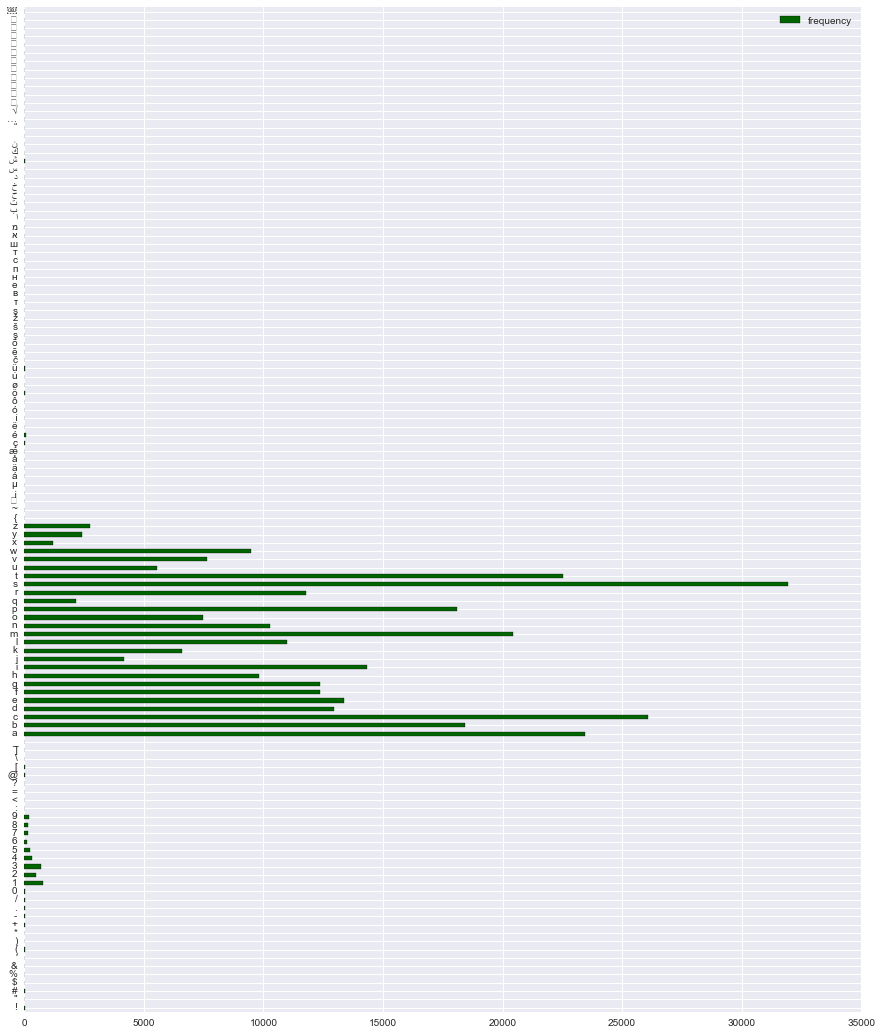

In [11]:
df_letters.plot(kind='barh', figsize=(15,18), color='darkgreen')

<h1>LDA analysis on Company Descriptions</h1>

In [28]:
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim

from nltk import sent_tokenize, word_tokenize
import nltk

In [13]:
# import re
# import ftfy

In [14]:
descriptions = df[pd.notnull(df['short_description'])]['short_description']

In [15]:
documents = []
for s in descriptions:
    documents.append([w.lower() for w in word_tokenize(s.decode('utf8'))])

In [16]:
unigrams = [ w for doc in documents for w in doc if len(w)==1]
bigrams  = [ w for doc in documents for w in doc if len(w)==2]

In [17]:
stoplist  = set(nltk.corpus.stopwords.words("english") + unigrams + bigrams)

In [18]:
# strip out stopwords
documents = [[token for token in doc if token not in stoplist]
                for doc in documents]

In [19]:
from collections import defaultdict
# Remove words that only occur once
token_frequency = defaultdict(int)

In [20]:
# count all token
for doc in documents:
    for token in doc:
        token_frequency[token] += 1

In [21]:
# keep words that occur more than once
documents = [ [token for token in doc if token_frequency[token] > 1]
                for doc in documents  ]

In [22]:
# Sort words in documents
for doc in documents:
    doc.sort()

In [23]:
# Build a dictionary where for each document each word has its own id
dictionary = corpora.Dictionary(documents)
dictionary.compactify()

In [24]:
# and save the dictionary for future use
dictionary.save('ODM_descriptions.dict')

In [25]:
print(dictionary)

Dictionary(46746 unique tokens: [u'nordisk', u'conent', u'1,800', u'localizes', u'woods']...)


In [26]:
# Build the corpus: vectors with occurence of each word for each document
# convert tokenized documents to vectors
corpus = [dictionary.doc2bow(doc) for doc in documents]
# ldacorpus = [dictionary.doc2bow(text) for text in corpus]

# and save in Market Matrix format
corpora.MmCorpus.serialize('CSR_corpus.mm', corpus)
# this corpus can be loaded with corpus = corpora.MmCorpus('alexip_followers.mm')

In [29]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, update_every=1, chunksize=10000, passes=10)

In [30]:
lda.print_topics(10)

[(15,
  u'0.042*search + 0.028*every + 0.026*right + 0.025*retail + 0.022*engine + 0.019*day + 0.018*children + 0.017*take + 0.012*visual + 0.011*hotel'),
 (20,
  u'0.051*news + 0.046*community + 0.046*network + 0.035*information + 0.024*social + 0.024*local + 0.022*food + 0.016*latest + 0.015*women + 0.014*ideas'),
 (4,
  u'0.058*energy + 0.039*commercial + 0.037*power + 0.025*projects + 0.020*printing + 0.018*residential + 0.016*solar + 0.015*restaurant + 0.015*government + 0.014*areas'),
 (8,
  u'0.047*experience + 0.042*startup + 0.037*organization + 0.028*door + 0.027*years + 0.024*source + 0.020*open + 0.020*working + 0.018*creative + 0.018*non-profit'),
 (14,
  u'0.035*number + 0.035*users + 0.034*people + 0.027*way + 0.026*find + 0.023*create + 0.022*time + 0.022*share + 0.021*music + 0.019*enables'),
 (18,
  u'0.140*development + 0.116*web + 0.106*design + 0.053*company + 0.051*real + 0.037*product + 0.037*estate + 0.025*custom + 0.024*website + 0.019*studio'),
 (21,
  u'0.043

In [31]:
lda.show_topics(num_topics=10, num_words=10, formatted=False)

[(19,
  [(u'university', 0.045289705775446283),
   (u'property', 0.034056780212279418),
   (u'consultancy', 0.032847600707313504),
   (u'specialized', 0.029750922934444188),
   (u'automation', 0.020651427273521848),
   (u'south', 0.02043503695991896),
   (u'equipment', 0.019098535027003736),
   (u'sale', 0.01562365840525724),
   (u'auto', 0.014939114438478927),
   (u'society', 0.01465008092708456)]),
 (6,
  [(u'solutions', 0.085274493813417604),
   (u'data', 0.062196406975412226),
   (u'provides', 0.031033553458936915),
   (u'cloud', 0.028802149499810383),
   (u'analytics', 0.021881936614525099),
   (u'provider', 0.01799410656072124),
   (u'platform', 0.017950027261509637),
   (u'call', 0.01660360199163544),
   (u'performance', 0.016448354479619367),
   (u'communication', 0.015050883215914175)]),
 (26,
  [(u'online', 0.16923375431767942),
   (u'free', 0.046402759457498825),
   (u'platform', 0.046360577094593),
   (u'marketplace', 0.038416246260449163),
   (u'travel', 0.0280364911378461

In [32]:
pyLDAvis_data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(pyLDAvis_data)

AttributeError: 'OrdinationResults' object has no attribute 'scores'

In [ ]:
# TODO:
# - map out locations of startups
# - nlp on short_description for fun
# - distributino of facebook, twitter, linkedin links, publicly traded etc.